**7장 – 앙상블 학습과 랜덤 포레스트**

_이 노트북은 7장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표기반 분류기

수업시간의 동전을 던질 때의 큰손의 법칙과 비슷하다.

In [5]:
heads_proba = 0.53
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

그림 저장: law_of_large_numbers_plot


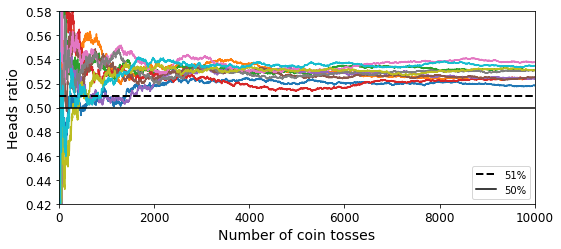

In [6]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**노트**: 향후 버전을 위해 사이킷런에서 기본 값이 될 `solver="lbfgs"`, `n_estimators=100`, `gamma="scale"`로 지정합니다.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
#변수명을 좀 알기 쉽게끔

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf',rnd_clf),('svc',svm_clf)], voting='hard' # 3가지 모델로 투표를 진행한다 , 'hard' : 3개 중 2개 이상인 것에 투표를 한다.
)# voting classifier 작성

voting_clf.fit(X_train,y_train)# voting classifier 학습

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


간접 투표:

In [16]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting= 'soft') # soft voting 작성)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [17]:
from sklearn.metrics import accuracy_score
import logging

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #logging(clf.__class__.__name__, accuracy_score(y_test, y_pred)) logging 을 활용해서 모델 학습의 로그 기록을 저장한다
    # 형식 : 로그 기록을 저장할 때는 정보를 최대한 자세하게 써놓기.
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) # clf.__class__.__name__ 에서 for 문으로 모델을 불러오기 때문에 모델에 사용하는 모든 모듈을 사용할 수 있다.

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅 앙상블

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,max_samples=100,bootstrap=True,random_state=42
)# bagging classifier 작성

bag_clf.fit(X_train,y_train)# bagging 학습

y_pred = bag_clf.predict((X_test))# test data set에 대한 예측

In [19]:
from sklearn.metrics import accuracy_score
# 정확도 출력

print(accuracy_score(y_pred,y_test)) # soft 보팅 보다는 낮지만 그래도 단일 모델보다는 성능이 좋다.

0.904


In [20]:
tree_clf = DecisionTreeClassifier(random_state=42)#단일 트리 선언
tree_clf.fit(X_train,y_train)# 트리 학습
y_pred_tree = tree_clf.predict(X_test)# test dataset 예측
print(accuracy_score(y_pred_tree,y_test)) #정확도 출력

0.856


In [21]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


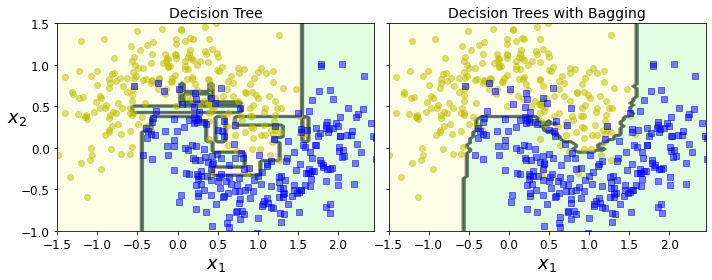

In [22]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

# 원래는 다 직각인데 여러개를 합치다보니 스무딩 효과가 발생해서 스무스해진다.

# 랜덤 포레스트

In [27]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=16, random_state=42),
    n_estimators=500,max_samples=1.0,bootstrap=True,random_state=42
)

# bagging classifier 선언, parameter: max leaf node는 16, 트리 개수 500개, max_sample = 1.0, 중복 추출 허용

In [28]:
bag_clf.fit(X_train,y_train)# bagging classifier 학습
bag_clf.predict(X_test)# test dataset 으로 예측

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [29]:
from sklearn.ensemble import RandomForestClassifier  ## max_depth 를 너무 깊게 하면 안된다.. n_ 이것도 너무 깊게는 X...

rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,random_state=42)# 위와 같은 조건으로 random forest 선언
rnd_clf.fit(X_train,y_train)# random forest classifier 학습
# 심플하게 구현할 수 있는 장점이 있어서 랜덤포레스트를 자주 사용한다.

y_pred_rf = rnd_clf.predict(X_test)# test dataset 으로 예측

In [30]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

0.976

In [32]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):# feature 별 중요도 추출 변수):
    print(name, score)

# score 의 합이 1이다.

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [33]:
rnd_clf.feature_importances_# feature 별 중요도 확인

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

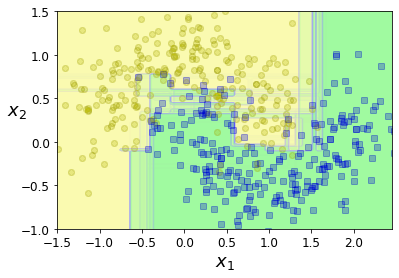

In [34]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## OOB 평가

In [51]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True,random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [36]:
bag_clf.oob_decision_function_# oob decision function 확인

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [37]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 특성 중요도

랜덤포레스트의 장점은 특성 중요도를 볼 수 있다.

In [54]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [55]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

RandomForestClassifier(random_state=42)

In [56]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


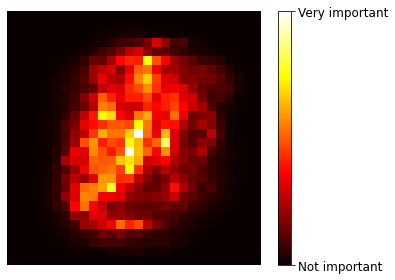

In [57]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# 에이다부스트

틀린 문제를 sample 로 뽑힐 수 있도록 확률을 높이는 방법

In [58]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=200,
    algorithm='SAMME.R',learning_rate=0.5,random_state=42
)# adaboost classifier 선언, parameter, depth 1, 트리수 200, 학습률 0.5, algorithmdms "SAMME.R"
# 가중치를 업데이트하면서 샘플을 계속 바뀌는 형태
# 여기서 learing rate 에 따라서 가중치를 어떻게 업데이트할 것인가를 설정

ada_clf.fit(X_train,y_train)# 학습

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

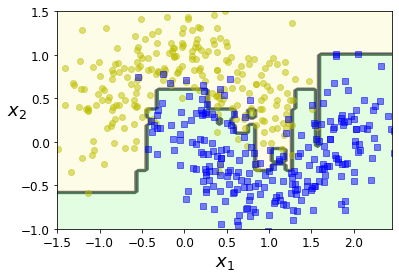

In [60]:
plot_decision_boundary(ada_clf, X, y)

그림 저장: boosting_plot


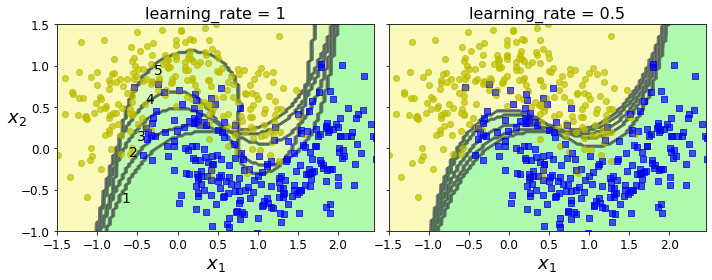

In [61]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [62]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_',
 'n_features_in_']

# 그레이디언트 부스팅

차이를 학습하는 알고리즘

In [64]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [65]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [66]:
y_pred = tree_reg1.predict(X)
y2 = y - y_pred # 작성
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [67]:
y3 = y2 - tree_reg2.predict(X)# 작성
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [71]:
X_new = np.array([[0.8]])
y_hat = tree_reg3.predict(X_new) + tree_reg2.predict(X_new) + tree_reg1.predict(X_new)
y_hat

array([0.75026781])

In [72]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))# 실제 예측값 계산

In [73]:
y_pred

array([0.75026781])

In [74]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


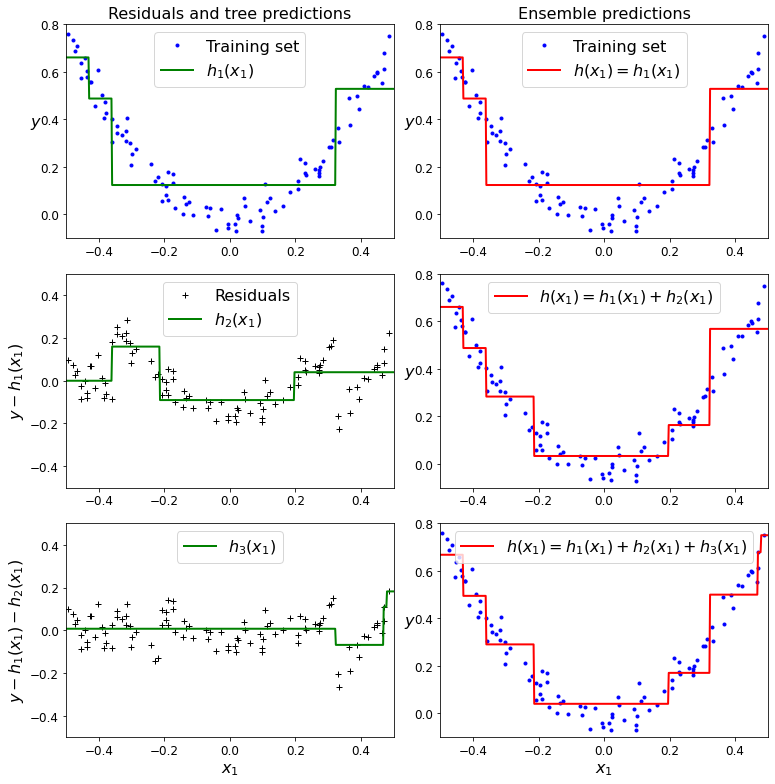

In [75]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [76]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0,random_state=42)# gradient boosting regression 작성, 위의 코드와 동일하게 작동하도록 작성
gbrt.fit(X,y)# 학습

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [85]:
gbrt_slow = GradientBoostingRegressor(max_depth=2,n_estimators=30,learning_rate=0.15,random_state=42)# gradient boosting 작성, 단 학습률 0.1로
gbrt_slow.fit(X, y)

GradientBoostingRegressor(learning_rate=0.15, max_depth=2, n_estimators=30,
                          random_state=42)

그림 저장: gbrt_learning_rate_plot


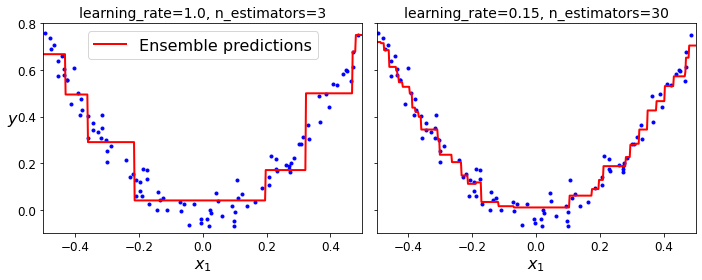

In [86]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## 조기 종료를 사용한 그래디언트 부스팅

3가지 방법이 있다.
다 돌려놓고 찾기, 정확도의 차이 보기

In [87]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [88]:
min_error = np.min(errors)

그림 저장: early_stopping_gbrt_plot


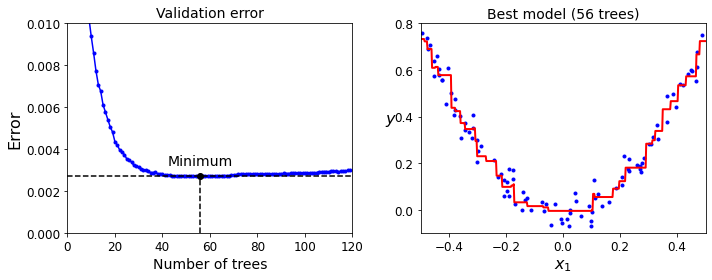

In [89]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [90]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):  # 규제 1 : 최대로 돌려도 120 까지만 돌린다.
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [91]:
print(gbrt.n_estimators)

61


In [93]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## XGBoost 사용하기 (직접 해보기)

In [94]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [95]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

Validation MSE: 0.004000408205406276


In [96]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


In [97]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

44.6 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

14.6 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
